# Mesterséges intelligencia projektfeladat
## Modell tanítás
Szükséges python modulok importálása

In [1]:
# Import with pandas
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import pickle
import datetime

Adatok beolvasása és ellenőrzése

In [3]:
df = pd.read_csv(r'..\data\202404_hun_mapillary_clean.csv', encoding='utf-8', delimiter=';')
pd.set_option('display.max_column',None)
df.head

<bound method NDFrame.head of            id  bicycle  bridge  crossing  oneway  junction  lanes  maxspeed  \
0       79020    False   False       0.0   False     False    2.0        50   
1        2693    False   False       0.0   False     False    2.0        50   
2        2699    False   False       1.0   False     False    3.0        50   
3        2711    False   False       0.0   False     False    2.0        50   
4        2712    False   False       0.0   False     False    3.0        50   
...       ...      ...     ...       ...     ...       ...    ...       ...   
143146  31384    False   False       0.0    True     False    3.0       110   
143147  36118    False   False       0.0    True     False    2.0        60   
143148  40222    False   False       0.0    True     False    0.0        50   
143149  44241    False   False       0.0    True     False    3.0        70   
143150  56127    False   False       0.0    True     False    2.0        90   

        maxweight  sm

Még egy utolsó ellenőrzés, hogy sehol ne legyen NULL érték

In [4]:
# df.isnull().any()
df.columns[df.isnull().any()]

Index([], dtype='object')

Felesleges oszlopok törlése az adott modell futtatásához

In [9]:
df_keep = df.drop(columns=['id', 'landuse_None', 'curv',
       'landuse_allotments', 'landuse_commercial', 'landuse_farmland',
       'landuse_forest', 'landuse_grass',
       'landuse_highway', 'landuse_industrial', 'landuse_meadow',
       'landuse_railway', 'landuse_residential','surface_asphalt',
       'surface_cobblestone', 'surface_compacted', 'surface_concrete',
       'surface_gravel', 'surface_other', 'surface_paved',
       'surface_paving_stones', 'surface_sett', 'surface_unpaved', 'landuse_retail',
       'landuse_vineyard',
       's_e_none','value_none', 'minute_none'])

In [8]:
# df_keep = df.drop(columns=['osm_id', 'landuse_None', 
#        'landuse_allotments',  'landuse_farmland',
#        'landuse_farmyard',  'landuse_grass',
#        'landuse_meadow',
#        'landuse_orchard', 'landuse_railway', 'landuse_retail',
#        'landuse_vineyard'])

KeyError: "['osm_id', 'landuse_farmyard', 'landuse_orchard'] not found in axis"

Megtartandó attribútumok ellenőrzése

In [10]:
df_keep.columns


Index(['bicycle', 'bridge', 'crossing', 'oneway', 'junction', 'lanes',
       'maxspeed', 'maxweight', 'smoothness', 'toll', 'tunnel', 'dens',
       'dens_l', 'angle_diff_90', 'angle_diff_180', 'highway_living_street',
       'highway_motorway', 'highway_motorway_link', 'highway_primary',
       'highway_primary_link', 'highway_residential', 'highway_secondary',
       'highway_secondary_link', 'highway_tertiary', 'highway_tertiary_link',
       'highway_trunk', 'highway_trunk_link', 'highway_unclassified',
       'surface_concrete:plates', 'surface_dirt', 'surface_fine_gravel',
       'surface_ground', 'surface_sand', 's_e_e', 's_e_s',
       'value_regulatory--end-of-maximum-speed-limit-30--g1',
       'value_regulatory--end-of-maximum-speed-limit-30--g2',
       'value_regulatory--end-of-maximum-speed-limit-40--g1',
       'value_regulatory--end-of-maximum-speed-limit-50--g1',
       'value_regulatory--end-of-maximum-speed-limit-50--g2',
       'value_regulatory--end-of-maximum-spe

Függvény a training, validation és test halmazok létrehozására

In [6]:

def get_dataset_partitions_pd(df, train_split=0.65, val_split=0.15, test_split=0.2):
    assert (train_split + test_split + val_split) == 1
    
    # Only allows for equal validation and test splits
    # assert val_split == test_split 

    # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(train_split * len(df)), int((1 - test_split) * len(df))]
    
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    
    return train_ds, val_ds, test_ds

Training, validation és test halmazok létrehozására és tensorrá konvertálása. (A *maxspeed* attribútum lesz címke.)

In [11]:

train_ds, val_ds, test_ds = get_dataset_partitions_pd(df_keep)

X_train = train_ds.drop(columns=['maxspeed'])
y_train = train_ds['maxspeed']
X_val = val_ds.drop(columns=['maxspeed'])
y_val = val_ds['maxspeed']
X_test = test_ds.drop(columns=['maxspeed'])
y_test = test_ds['maxspeed']

# Could use df.pop() instead
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_val   = tf.convert_to_tensor(X_val)
y_val   = tf.convert_to_tensor(y_val)
X_test  = tf.convert_to_tensor(X_test)
y_test  = tf.convert_to_tensor(y_test)

y_train_np = np.array(y_train)
y_val_np = np.array(y_val)
y_test_np = np.array(y_test)


Értéktérkép készítése a címkékhez

In [16]:
# Map speed limits to sequential integers starting from 0
speed_limits = pd.unique(df['maxspeed'])
speed_limits.sort()
speed_limits_map = {speed_limits[i]: i for i in range(len(speed_limits))}

y_train_mapped = np.array(list(map(speed_limits_map.get, y_train_np)))
y_val_mapped = np.array(list(map(speed_limits_map.get, y_val_np)))
y_test_mapped = np.array(list(map(speed_limits_map.get, y_test_np)))

# Convert y_train to one-hot encoding
from tensorflow.keras.utils import to_categorical
y_train_encoded = to_categorical(y_train_mapped, num_classes=len(speed_limits_map))
y_val_encoded = to_categorical(y_val_mapped, num_classes=len(speed_limits_map))
y_test_encoded = to_categorical(y_test_mapped, num_classes=len(speed_limits_map))


## Modell tanítás
Modell rétegek meghatározása

In [35]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(2048, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(2048, activation="relu"),
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1024, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(256, activation="relu"),
    # layers.Dense(256, activation="relu"),
    # layers.Dropout(0.2),
    # layers.Dense(512, activation="relu"),
    # layers.Dropout(0.2),
    # layers.Dense(256, activation="relu"),
    # layers.Dropout(0.2),
    # layers.Dense(128, activation="relu"),
    layers.Dense(pd.unique(df['maxspeed']).size, activation="softmax")
])

Modell paraméterek beállítása

In [36]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy",keras.metrics.CategoricalAccuracy()])

Modell tanítása

In [37]:
history = model.fit(X_train,
                    y_train_encoded,
                    epochs=35,
                    batch_size=512,
                    validation_data=(X_val,y_val_encoded))

# save_results("train_osm_inrix_v0")

Epoch 1/35
182/182 [==============================] - 46s 244ms/step - loss: 1.5586 - accuracy: 0.4952 - categorical_accuracy: 0.4952 - val_loss: 0.9735 - val_accuracy: 0.6421 - val_categorical_accuracy: 0.6421
Epoch 2/35
182/182 [==============================] - 47s 260ms/step - loss: 0.9388 - accuracy: 0.6358 - categorical_accuracy: 0.6358 - val_loss: 0.9167 - val_accuracy: 0.6581 - val_categorical_accuracy: 0.6581
Epoch 3/35
182/182 [==============================] - 48s 262ms/step - loss: 0.8792 - accuracy: 0.6661 - categorical_accuracy: 0.6661 - val_loss: 0.8567 - val_accuracy: 0.6813 - val_categorical_accuracy: 0.6813
Epoch 4/35
182/182 [==============================] - 48s 263ms/step - loss: 0.8489 - accuracy: 0.6799 - categorical_accuracy: 0.6799 - val_loss: 0.8611 - val_accuracy: 0.6865 - val_categorical_accuracy: 0.6865
Epoch 5/35
182/182 [==============================] - 48s 263ms/step - loss: 0.8346 - accuracy: 0.6838 - categorical_accuracy: 0.6838 - val_loss: 0.8217 - v

Accuracy és loss megjelenítése

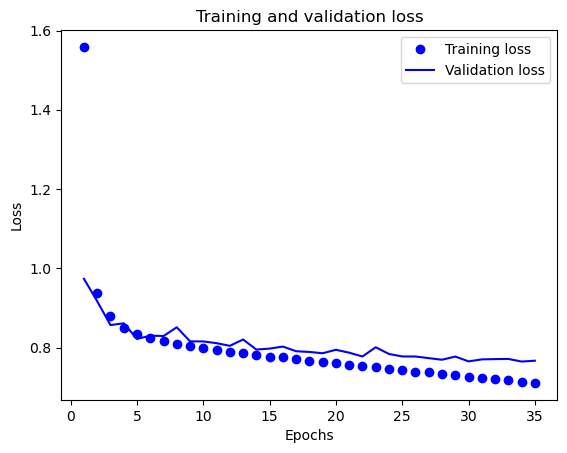

In [38]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label ="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

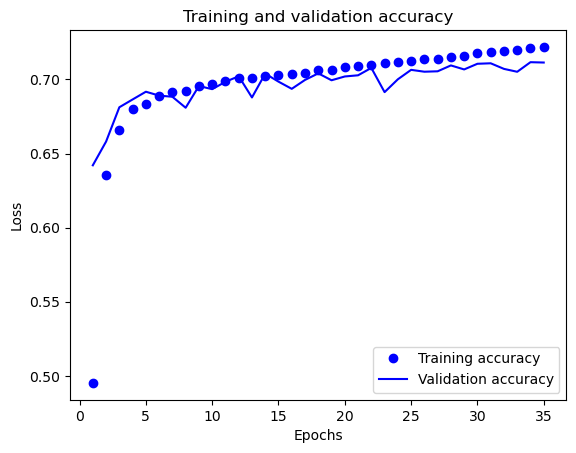

In [39]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["accuracy"]
val_loss_values = history_dict["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training accuracy")
plt.plot(epochs, val_loss_values, "b", label ="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["categorical_accuracy"]
val_loss_values = history_dict["val_categorical_accuracy"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training categorical accuracy")
plt.plot(epochs, val_loss_values, "b", label ="Validation categorical accuracy")
plt.title("Training and validation categorical accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Adatok elmentése

In [41]:
# Save results
# In Jupyter notebook this does not work:
# original_file_name = os.path.basename(__file__).split('.')[0]

original_file_name = os.path.basename("train_osm_inrix_v0.ipynb").split('.')[0]
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

model_filename = f"../results/{original_file_name}_{current_date}_model.keras"
model.save(model_filename)

history_filename = f"../results/{original_file_name}_{current_date}_history.pkl"
with open(history_filename, 'wb') as file:
    pickle.dump(history.history, file)

# Save parameters and results as a CSV
csv_filename = f"../results/{original_file_name}_{current_date}_results.csv"
# Check if CSV file exists
if not os.path.exists(csv_filename):
    # Create a new DataFrame
    results_df = pd.DataFrame(columns=['date', 'epochs', 'num_hidden_layers', 'size_hidden_layers', 'df_columns', 'df_keep_columns', 'loss', 'accuracy', 'val_loss', 'val_accuracy'])
else:
    # Load existing DataFrame from CSV
    results_df = pd.read_csv(csv_filename)
# Append current results
current_results = {
    'date': current_date,
    'epochs': len(history.history['loss']),
    'num_hidden_layers': len(model.layers),
    'size_hidden_layers': [layer.units for layer in model.layers if hasattr(layer, 'units')],
    'df_columns': df.columns.tolist(),
    'df_keep_columns': df_keep.columns.tolist(),
    'loss': history.history['loss'][-1],
    'accuracy': history.history['accuracy'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_accuracy': history.history['val_accuracy'][-1],
    'model_file': model_filename,
    'history_file': history_filename
}

# Add the data to the DataFrame
results_df.loc[results_df.index.max() + 1] = current_results

# Save DataFrame to CSV
results_df.to_csv(csv_filename, index=False)

## Predikció

Modell betöltése (arra az esetre ha más modellt akarnánk használni)

In [42]:
loaded_model = keras.saving.load_model(model_filename)

#Load previous results
with open(history_filename, 'rb') as file:
    loaded_history = pickle.load(file)


Prediktált értékek meghatározása a modell alapján, és konvertálása megfelelő formátumra

In [56]:
y_pred = model.predict(X_test)

predicted_indices = np.argmax(y_pred, axis=1)

# Map the indices back to the original speed limit values using the speed_limits array
predicted_speed_limits = [speed_limits[i] for i in predicted_indices]

895/895 [==============================] - 13s 15ms/step


Eredmények összehasonlítása igazságmátrixal

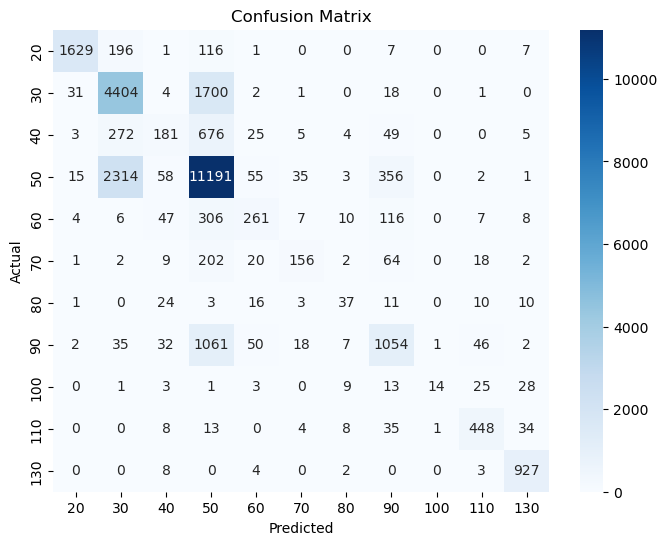

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_speed_limits)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues',  fmt='g', xticklabels=speed_limits, yticklabels=speed_limits)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [57]:
results = model.evaluate(X_test,y_test_encoded,batch_size=128)
print("test loss, test acc:", results)
results_l = loaded_model.evaluate(X_test,y_test_encoded,batch_size=128)
print("test loss, test acc:", results_l)

224/224 [==============================] - 5s 23ms/step - loss: 0.7649 - accuracy: 0.7091 - categorical_accuracy: 0.7091
test loss, test acc: [0.7648743987083435, 0.7090915441513062, 0.7090915441513062]
224/224 [==============================] - 6s 23ms/step - loss: 0.7649 - accuracy: 0.7091 - categorical_accuracy: 0.7091
test loss, test acc: [0.7648743987083435, 0.7090915441513062, 0.7090915441513062]


In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 2048)              122880    
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_11 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_12 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_5 (Dropout)         (None, 1024)             